### __Notebook to verify that looking at temperature amplitude ratio is interesting for a diffusive problem in the monodirectional case__ ###


In [86]:
#Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk 
from pyheatmy import * 
from pyheatmy.time_series_multiperiodic import time_series_multiperiodic

from sklearn import linear_model
from pyheatmy.core import *
import scipy

In [68]:
#On commence par créer un signal d'entrée grace à la classe time_series_multiperiodic, que l'on forcera dans la classe Synthetic_Molonari ensuite

T_riv = time_series_multiperiodic("multi_periodic")

#On regarde des variations de température sur une année, on définit une période journalière, et une période annuelle

T_MOY_ANNUELLE = 12 + ZERO_CELSIUS #°C, représente l'offset commun de nos signaux de température

T_AMP_ANNUELLE = 6 #°C, représente l'amplitude de variation de température annuelle

T_AMP_JOURNALIERE = 1 #°C, représente l'amplitude de variation de température journalière

P_an = 12 #Période annuelle en mois

P_jour = 24 #Période journalière, en heures

t_debut = (2024, 4, 15, 8, 0, 0) #On commence le 15 avril 2024 à 8h00
t_fin = (2024, 8, 15, 8, 0, 0) #On finit le 15 avril 2025 à 8h00, on regarde ce qu'il se passe sur un an. 
dt = 15*NSECINMIN #On se place dans le cas d'un point de mesure toutes les 15 minutes

In [69]:
#Ensuite, on commence par créer un objet synthetic_MOLONARI pour pouvoir utiliser ses méthodes (et en particulier accéder à son générateur de dates)

"""Conditions limites"""
# Température de la rivière
zeroT = 0
zeroT += ZERO_CELSIUS  #time_series works only with forcings in celsius. See if it is deeper in pyheatmy or not

T_riv_amp = 5
T_riv_offset = 20  + zeroT
nday = 3
P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
# Température de l'aquifère
T_aq_amp = 0
T_aq_offset = 14 + zeroT
P_T_aq = -9999 # à mettre dans le init
# Pression différentielle
dH_amp = 0
dH_offset = 0.5 #1meter ?
P_dh = -9999 #14*24*4*dt


depth_sensors = [.1, .2, .3, .4]
Zbottom = 0.4

"""Bruit de mesure"""
sigma_meas_P = 0.001
sigma_meas_T = 0.1

print("dt={0:.1f}s".format(dt))

dt=900.0s


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 8, 15, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.5]
param_T_riv_signal: [5, 259200, 293.15]
param_T_aq_signal: [0, -9999, 287.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.5, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 5, period of 259200, offset 293.15, dt 900 --> 
periodic signal



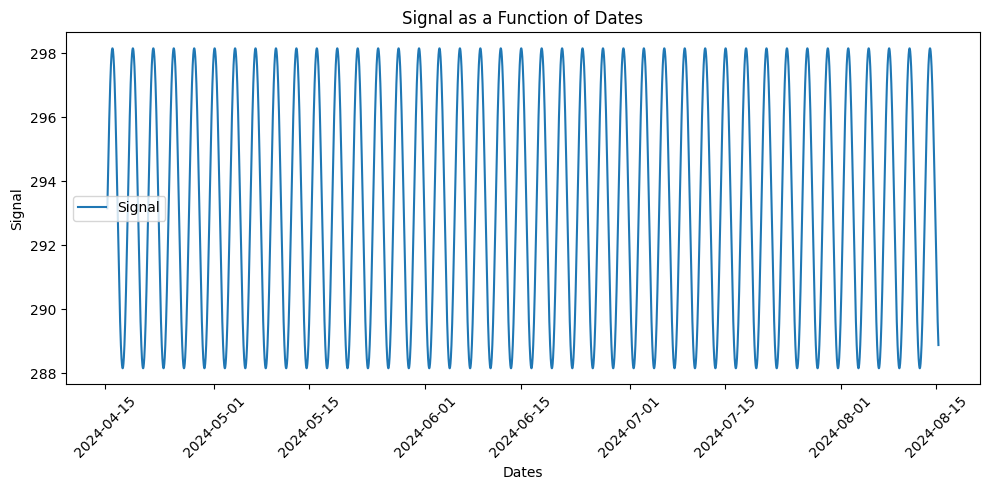

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  ... 288.53198895 288.48728208
 288.44408048]
Temperature of Sensor 1 : [290.15       290.20453721 290.25904847 ... 288.07132597 288.04152139
 288.01272032]
Temperature of Sensor 2 : [288.65       288.67726861 288.70452423 ... 287.61066298 287.59576069
 287.58136016]
Temperature of Sensor 3 : [287.15 287.15 287.15 ... 287.15 287.15 287.15]


In [70]:
"""Reprise du code de dmo_genData pour créer un objet synthetic_MOLONARI"""
# un dictionnaire qui facilite le paramétrage avec des variables globales définies plus haut
time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, #float
}
# instanciation du simulateur de données
emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)


In [71]:
#On print l'attribut date de l'objet créé pour voir si la forme convient 

print(f"Dates : {emu_observ_test_user1._dates}")

Dates : [datetime.datetime(2024, 4, 15, 8, 0)
 datetime.datetime(2024, 4, 15, 8, 15)
 datetime.datetime(2024, 4, 15, 8, 30) ...
 datetime.datetime(2024, 8, 15, 7, 15)
 datetime.datetime(2024, 8, 15, 7, 30)
 datetime.datetime(2024, 8, 15, 7, 45)]


Creating a multi-periodic signal, with the following period: [[12, 'm'], [24, 'h']] and the following amplitude: [6, 1]
periods : [31104000, [24, 'h']]
periods : [31104000, 86400]


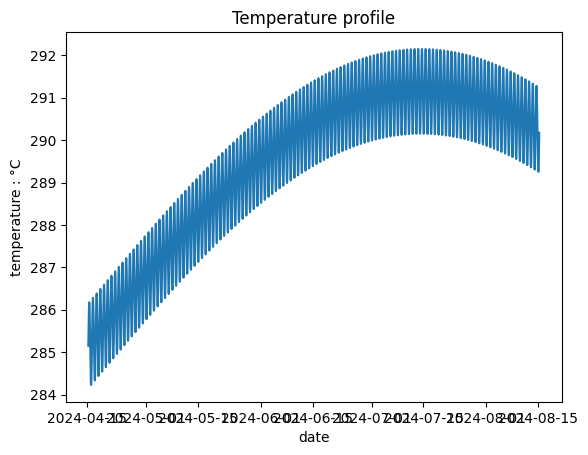

In [72]:
#On utilise le jeu de date précédent pour créer un signal de température multipériodique 

T_riv.create_multiperiodic_signal([T_AMP_ANNUELLE, T_AMP_JOURNALIERE], [[P_an, 'm'], [P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)

T_riv.plot() #On affiche le signal de température créé

In [73]:
#On force la variable T_riv dans l'objet emu_observ_test_user1

emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

#Puis on applique les méthodes _generate_Shaft_Temp_series et _generate_perturb_Shaft_Temp_series pour changer les valeurs dépendante du nouveau T_riv

emu_observ_test_user1._generate_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_T_riv_dH_series()

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.65       285.69987047 285.74953089 ... 289.32119874 289.36918861
 289.41759756]
Temperature of Sensor 1 : [286.15       286.18324698 286.21635393 ... 288.59746583 288.62945908
 288.66173171]
Temperature of Sensor 2 : [286.65       286.66662349 286.68317696 ... 287.87373291 287.88972954
 287.90586585]
Temperature of Sensor 3 : [287.15 287.15 287.15 ... 287.15 287.15 287.15]


In [74]:
#on génère un objet colonne à partir de l'objet emu_observ_test_user1

name ="Couche en sable"
zLow = Zbottom
moinslog10IntrinK = 11
n = 0.1
lambda_s = 2 # test cas purement advectif
rhos_cs = 4e6

# modèle une couche
layers_list= layersListCreator([(name, zLow, moinslog10IntrinK, n, lambda_s, rhos_cs)])

print(f"Layers list: {layers_list}")

# on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
col_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user1._molonariP_data,
    "T_measures": emu_observ_test_user1._molonariT_data,
    "sigma_meas_P": 0.01, #float
    "sigma_meas_T": 0.1, #float
}
col = Column.from_dict(col_dict,verbose=True)

Layers list: [Couche en sable : ends at 0.4 m. Parametres(moinslog10IntrinK=11, n=0.1, lambda_s=2, rhos_cs=4000000.0)]
Column created with success
Number of time steps: 11712
Time step in days: 0.010415777265482696
T_riv: [285.23049612 285.26387219 285.10370213 ... 289.87337314 290.30842189
 290.21168681]
T_aq: [287.10185753 286.98574483 287.22119041 ... 287.20333488 287.16875996
 287.15671555]
dH : [0.50065416 0.50016888 0.50124752 ... 0.49820318 0.4987097  0.50024823]
list of dates   : [datetime.datetime(2024, 4, 15, 8, 0), datetime.datetime(2024, 4, 15, 8, 15), datetime.datetime(2024, 4, 15, 8, 30), datetime.datetime(2024, 4, 15, 8, 45), datetime.datetime(2024, 4, 15, 9, 0), datetime.datetime(2024, 4, 15, 9, 15), datetime.datetime(2024, 4, 15, 9, 30), datetime.datetime(2024, 4, 15, 9, 45), datetime.datetime(2024, 4, 15, 10, 0), datetime.datetime(2024, 4, 15, 10, 15), datetime.datetime(2024, 4, 15, 10, 30), datetime.datetime(2024, 4, 15, 10, 45), datetime.datetime(2024, 4, 15, 11, 0)

In [75]:
nb_cells=20 # nombre de cellules, une tous les 5 centimètres 

col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=True)

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 11, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Solving the flow with intrinsec permeability 1e-11, and permeability 9.810000000000001e-05
Done.


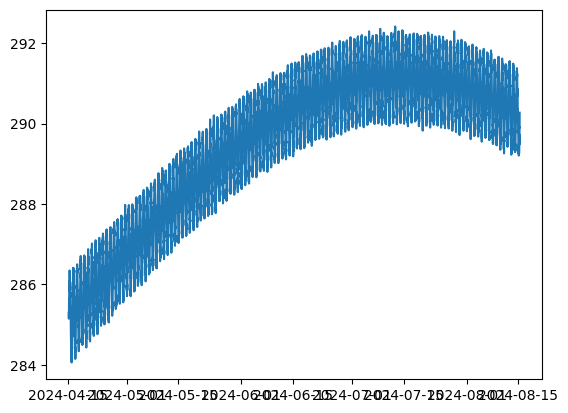

In [82]:
#On vérifie que les températures ont bien été modifiées dans l'objet column (en particulier que la température à profondeur nulle est bien celle de la rivière)

plt.plot(emu_observ_test_user1._dates, col._temperatures[0,:])
plt.show()

In [77]:
print(f"La matrice de température a pour shape : {col._temperatures.shape}, abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps")

La matrice de température a pour shape : (20, 11712), abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps


In [78]:
#On définit une fonction pour pouvoir compiler en faisant varier la valeur de la charge (et donc le régime infiltration ou exfiltration vers la 
#rivière) ainsi que la valeur de la porosité (et donc le régime de diffusion de la chaleur - majoritairement diffusif ou advectif)

def profil_temperature(offset_H, moinslog10IntrinK): 
    """Conditions limites"""
    # Température de la rivière
    zeroT = 0
    zeroT += ZERO_CELSIUS  #time_series works only with forcings in celsius. See if it is deeper in pyheatmy or not

    T_riv_amp = 5
    T_riv_offset = 20  + zeroT
    nday = 3
    P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
    # Température de l'aquifère
    T_aq_amp = 0
    T_aq_offset = 14 + zeroT
    P_T_aq = -9999 # à mettre dans le init
    # Pression différentielle
    dH_amp = 0
    P_dh = -9999 #14*24*4*dt


    depth_sensors = [.1, .2, .3, .4]
    Zbottom = 0.4

    """Bruit de mesure"""
    sigma_meas_P = 0.001
    sigma_meas_T = 0.1
    time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, offset_H], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, 
}
    emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)
    
    T_riv.create_multiperiodic_signal([T_AMP_ANNUELLE, T_AMP_JOURNALIERE], [[P_an, 'm'], [P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)
    emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

    emu_observ_test_user1._generate_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_T_riv_dH_series()
    name ="Couche en sable"
    zLow = Zbottom
    n = 0.1
    lambda_s = 2 # test cas purement advectif
    rhos_cs = 4e6

    # modèle une couche
    layers_list= layersListCreator([(name, zLow, moinslog10IntrinK, n, lambda_s, rhos_cs)])

    print(f"Layers list: {layers_list}")

    # on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
    col_dict = {
        "river_bed": 1., 
        "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
        "offset": .0,
        "dH_measures": emu_observ_test_user1._molonariP_data,
        "T_measures": emu_observ_test_user1._molonariT_data,
        "sigma_meas_P": 0.01, #float
        "sigma_meas_T": 0.1, #float
    }
    col = Column.from_dict(col_dict,verbose=False)
    nb_cells=20 # nombre de cellules, une tous les 5 centimètres 

    col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=True)
    return col._temperatures



In [84]:
# Argument : la matrice, liste des profondeur
# Sortie : liste des amplitudes
def amplitude(T):
    amplitude_list = []
    for j in range(len(T[0,:])):
        T_max = max(T[:,j])
        T_min = min(T[:,j])
        A = (T_max - T_min) / 2
        amplitude_list.append(A)
    return amplitude_list


# Retourne ln(rapport des amplitudes) en fonction de la profondeur
def ln_amp(T):
    amplitude_list = amplitude(T)
    amplitude_array = np.array(amplitude_list)
    ln_rapport_amplitude = np.log( amplitude_array / amplitude_array[0] )
    return ln_rapport_amplitude


# Trace le ln_temp(T) en fonction de depths
def plot_ln_amp(depths, T):
    y = ln_amp(T)
    plt.plot(depths, y)
    plt.title("Logarithme du rapport des amplitudes")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.show()


# Renvoie l'instance de régression linéaire des données (profondeur, ln(rapport amplitudes))
def linear_regression(depths, T):
    y = ln_amp(T)
    return scipy.stats.linregress(depths, y)


# Trace l'interpolation linéaire en imprimant le coefficient d'exactitude
def plot_linear_regression(depths, T):
    # assert len(T) == lent(depths), "a temperature measure must be assigned to a single depth"
    X = np.array(depths).reshape(-1,1)
    Y = ln_amp(T)
    Lr = linear_regression(depths, T)
    Pearson_coefficient = Lr.rvalue
    slope = Lr.slope
    intercept = Lr.intercept
    lm = linear_model.LinearRegression()
    lm.fit(X, Y)
    plt.scatter(X, Y, color="r", marker="o", s=30)
    y_pred = lm.predict(X)
    plt.plot(X, y_pred, color="k")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.title("Régression linéaire sur le rapport des logarithmes des amplitudes")
    plt.figtext(.6, .8, "y = " + str(slope) + "x + " + str(intercept))
    plt.figtext(.6, .7, "Pearson coefficient : " + str(Pearson_coefficient))
    plt.show()


# Mosaïque des différentes courbes en fonction des valeurs de K (list_K = liste de ces valeurs)
# T est la liste des matrices de températures pour différentes valeurs de K
def plot_mosaic(depths, list_T, list_K):  
    # assert len(list_T[0]) == lent(depths), "a temperature measure must be assigned to a single depth"
    assert len(list_T) == len(list_K), 'The number of K values does not match the number a temperature matrices'
    n_rows = len(list_K)//2 + len(list_K)%2
    _, ax = plt.subplots(n_rows, ncols=2)
    X = np.array(depths).reshape(-1,1)
    for i in range(n_rows):
        for j in range(2):
            Y = ln_amp(list_T[2*i+j])
            Lr = linear_regression(depths, list_T[2*i+j])
            Pearson_coefficient = Lr.rvalue
            slope = Lr.slope
            intercept = Lr.intercept
            lm = linear_model.LinearRegression()
            lm.fit(X, Y)
            ax[i][j].scatter(X, Y, color="r", marker="o", s=30)
            y_pred = lm.predict(X)
            ax[i][j].plot(X, y_pred, color="k")
            ax[i][j].set_xlabel('profondeur (unit)')
            ax[i][j].set_ylabel('température')
            ax[i][j].set_title('Rapport des ln(A_z / A_0) avec K =' + str(list_K[2*i] + j), size = 10)   
            ax[i][j].legend(["Pearson coefficient : " + str(Pearson_coefficient)])


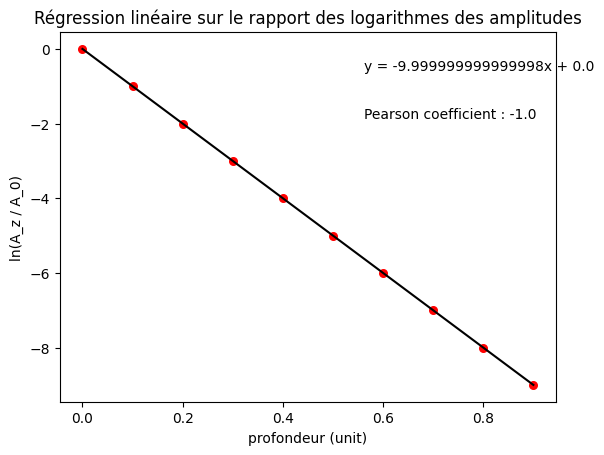

In [87]:
# test de plot_linear_regression
# Création d'un jeu de données arbitraire :

T = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        T[i,j] = np.sin(i) * np.exp(-j)

depths = [0.1 * i for i in range(10)]

plot_linear_regression(depths, T)


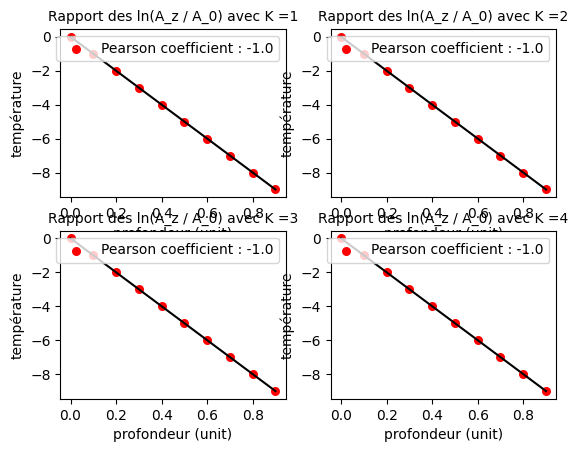

In [88]:
# test de plot_mosaic
# Création de 4 valeurs de K absurde

list_K = range(1,5)
list_T = [T for _ in range(4)]

plot_mosaic(depths,list_T,list_K)